In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                                                       | 0/50000 [00:00<?, ?it/s]

  9%|███████████▉                                                                                                                             | 4357/50000 [00:00<00:01, 43565.06it/s]

 18%|███████████████████████▉                                                                                                                 | 8751/50000 [00:00<00:00, 43782.49it/s]

 26%|███████████████████████████████████▋                                                                                                    | 13138/50000 [00:00<00:00, 43819.51it/s]

 35%|███████████████████████████████████████████████▋                                                                                        | 17547/50000 [00:00<00:00, 43923.20it/s]

 44%|███████████████████████████████████████████████████████████▋                                                                            | 21940/50000 [00:00<00:00, 43863.26it/s]

 53%|███████████████████████████████████████████████████████████████████████▌                                                                | 26327/50000 [00:00<00:00, 43803.28it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▋                                                    | 30747/50000 [00:00<00:00, 43930.08it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 35144/50000 [00:00<00:00, 43940.85it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 39565/50000 [00:00<00:00, 44021.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 43978/50000 [00:01<00:00, 44053.32it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 48384/50000 [00:01<00:00, 43994.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43902.23it/s]

Files already downloaded and verified


  0%|                                                                                                                                                       | 0/10000 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████▊                                                                             | 4368/10000 [00:00<00:00, 43672.13it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8745/10000 [00:00<00:00, 43724.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 43599.52it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 yk4jbpb0


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                         | 0/313 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/313 [00:01<07:35,  1.46s/it]

  1%|▉                                                                                                                                                | 2/313 [00:01<03:30,  1.48it/s]

  1%|█▍                                                                                                                                               | 3/313 [00:01<02:11,  2.35it/s]

  1%|█▊                                                                                                                                               | 4/313 [00:01<01:35,  3.25it/s]

  2%|██▎                                                                                                                                              | 5/313 [00:01<01:14,  4.11it/s]

  2%|██▊                                                                                                                                              | 6/313 [00:02<01:02,  4.90it/s]

  2%|███▏                                                                                                                                             | 7/313 [00:02<00:54,  5.59it/s]

  3%|███▋                                                                                                                                             | 8/313 [00:02<00:49,  6.14it/s]

  3%|████▏                                                                                                                                            | 9/313 [00:02<00:46,  6.58it/s]

  3%|████▌                                                                                                                                           | 10/313 [00:02<00:43,  6.92it/s]

  4%|█████                                                                                                                                           | 11/313 [00:02<00:42,  7.17it/s]

  4%|█████▌                                                                                                                                          | 12/313 [00:02<00:40,  7.35it/s]

  4%|█████▉                                                                                                                                          | 13/313 [00:02<00:40,  7.49it/s]

  4%|██████▍                                                                                                                                         | 14/313 [00:03<00:39,  7.58it/s]

  5%|██████▉                                                                                                                                         | 15/313 [00:03<00:39,  7.64it/s]

  5%|███████▎                                                                                                                                        | 16/313 [00:03<00:38,  7.69it/s]

  5%|███████▊                                                                                                                                        | 17/313 [00:03<00:38,  7.73it/s]

  6%|████████▎                                                                                                                                       | 18/313 [00:03<00:38,  7.75it/s]

  6%|████████▋                                                                                                                                       | 19/313 [00:03<00:37,  7.77it/s]

  6%|█████████▏                                                                                                                                      | 20/313 [00:03<00:37,  7.78it/s]

  7%|█████████▋                                                                                                                                      | 21/313 [00:04<00:37,  7.80it/s]

  7%|██████████                                                                                                                                      | 22/313 [00:04<00:37,  7.80it/s]

  7%|██████████▌                                                                                                                                     | 23/313 [00:04<00:37,  7.80it/s]

  8%|███████████                                                                                                                                     | 24/313 [00:04<00:37,  7.80it/s]

  8%|███████████▌                                                                                                                                    | 25/313 [00:04<00:36,  7.81it/s]

  8%|███████████▉                                                                                                                                    | 26/313 [00:04<00:36,  7.81it/s]

  9%|████████████▍                                                                                                                                   | 27/313 [00:04<00:36,  7.81it/s]

  9%|████████████▉                                                                                                                                   | 28/313 [00:04<00:36,  7.81it/s]

  9%|█████████████▎                                                                                                                                  | 29/313 [00:05<00:36,  7.81it/s]

 10%|█████████████▊                                                                                                                                  | 30/313 [00:05<00:36,  7.82it/s]

 10%|██████████████▎                                                                                                                                 | 31/313 [00:05<00:36,  7.82it/s]

 10%|██████████████▋                                                                                                                                 | 32/313 [00:05<00:36,  7.80it/s]

 11%|███████████████▏                                                                                                                                | 33/313 [00:05<00:35,  7.79it/s]

 11%|███████████████▋                                                                                                                                | 34/313 [00:05<00:35,  7.80it/s]

 11%|████████████████                                                                                                                                | 35/313 [00:05<00:35,  7.81it/s]

 12%|████████████████▌                                                                                                                               | 36/313 [00:05<00:35,  7.81it/s]

 12%|█████████████████                                                                                                                               | 37/313 [00:06<00:35,  7.82it/s]

 12%|█████████████████▍                                                                                                                              | 38/313 [00:06<00:35,  7.82it/s]

 12%|█████████████████▉                                                                                                                              | 39/313 [00:06<00:35,  7.81it/s]

 13%|██████████████████▍                                                                                                                             | 40/313 [00:06<00:34,  7.81it/s]

 13%|██████████████████▊                                                                                                                             | 41/313 [00:06<00:34,  7.81it/s]

 13%|███████████████████▎                                                                                                                            | 42/313 [00:06<00:34,  7.82it/s]

 14%|███████████████████▊                                                                                                                            | 43/313 [00:06<00:34,  7.82it/s]

 14%|████████████████████▏                                                                                                                           | 44/313 [00:06<00:34,  7.82it/s]

 14%|████████████████████▋                                                                                                                           | 45/313 [00:07<00:34,  7.81it/s]

 15%|█████████████████████▏                                                                                                                          | 46/313 [00:07<00:34,  7.81it/s]

 15%|█████████████████████▌                                                                                                                          | 47/313 [00:07<00:34,  7.81it/s]

 15%|██████████████████████                                                                                                                          | 48/313 [00:07<00:33,  7.81it/s]

 16%|██████████████████████▌                                                                                                                         | 49/313 [00:07<00:33,  7.81it/s]

 16%|███████████████████████                                                                                                                         | 50/313 [00:07<00:33,  7.81it/s]

 16%|███████████████████████▍                                                                                                                        | 51/313 [00:07<00:33,  7.81it/s]

 17%|███████████████████████▉                                                                                                                        | 52/313 [00:07<00:33,  7.81it/s]

 17%|████████████████████████▍                                                                                                                       | 53/313 [00:08<00:33,  7.81it/s]

 17%|████████████████████████▊                                                                                                                       | 54/313 [00:08<00:33,  7.81it/s]

 18%|█████████████████████████▎                                                                                                                      | 55/313 [00:08<00:33,  7.81it/s]

 18%|█████████████████████████▊                                                                                                                      | 56/313 [00:08<00:32,  7.81it/s]

 18%|██████████████████████████▏                                                                                                                     | 57/313 [00:08<00:32,  7.81it/s]

 19%|██████████████████████████▋                                                                                                                     | 58/313 [00:08<00:32,  7.81it/s]

 19%|███████████████████████████▏                                                                                                                    | 59/313 [00:08<00:32,  7.82it/s]

 19%|███████████████████████████▌                                                                                                                    | 60/313 [00:09<00:32,  7.82it/s]

 19%|████████████████████████████                                                                                                                    | 61/313 [00:09<00:32,  7.82it/s]

 20%|████████████████████████████▌                                                                                                                   | 62/313 [00:09<00:32,  7.81it/s]

 20%|████████████████████████████▉                                                                                                                   | 63/313 [00:09<00:31,  7.81it/s]

 20%|█████████████████████████████▍                                                                                                                  | 64/313 [00:09<00:31,  7.81it/s]

 21%|█████████████████████████████▉                                                                                                                  | 65/313 [00:09<00:31,  7.82it/s]

 21%|██████████████████████████████▎                                                                                                                 | 66/313 [00:09<00:31,  7.82it/s]

 21%|██████████████████████████████▊                                                                                                                 | 67/313 [00:09<00:31,  7.82it/s]

 22%|███████████████████████████████▎                                                                                                                | 68/313 [00:10<00:31,  7.82it/s]

 22%|███████████████████████████████▋                                                                                                                | 69/313 [00:10<00:31,  7.82it/s]

 22%|████████████████████████████████▏                                                                                                               | 70/313 [00:10<00:31,  7.82it/s]

 23%|████████████████████████████████▋                                                                                                               | 71/313 [00:10<00:30,  7.82it/s]

 23%|█████████████████████████████████                                                                                                               | 72/313 [00:10<00:30,  7.82it/s]

 23%|█████████████████████████████████▌                                                                                                              | 73/313 [00:10<00:30,  7.81it/s]

 24%|██████████████████████████████████                                                                                                              | 74/313 [00:10<00:30,  7.81it/s]

 24%|██████████████████████████████████▌                                                                                                             | 75/313 [00:10<00:30,  7.82it/s]

 24%|██████████████████████████████████▉                                                                                                             | 76/313 [00:11<00:30,  7.81it/s]

 25%|███████████████████████████████████▍                                                                                                            | 77/313 [00:11<00:30,  7.81it/s]

 25%|███████████████████████████████████▉                                                                                                            | 78/313 [00:11<00:30,  7.82it/s]

 25%|████████████████████████████████████▎                                                                                                           | 79/313 [00:11<00:29,  7.82it/s]

 26%|████████████████████████████████████▊                                                                                                           | 80/313 [00:11<00:29,  7.82it/s]

 26%|█████████████████████████████████████▎                                                                                                          | 81/313 [00:11<00:29,  7.82it/s]

 26%|█████████████████████████████████████▋                                                                                                          | 82/313 [00:11<00:29,  7.82it/s]

 27%|██████████████████████████████████████▏                                                                                                         | 83/313 [00:11<00:29,  7.82it/s]

 27%|██████████████████████████████████████▋                                                                                                         | 84/313 [00:12<00:29,  7.82it/s]

 27%|███████████████████████████████████████                                                                                                         | 85/313 [00:12<00:29,  7.82it/s]

 27%|███████████████████████████████████████▌                                                                                                        | 86/313 [00:12<00:29,  7.82it/s]

 28%|████████████████████████████████████████                                                                                                        | 87/313 [00:12<00:28,  7.82it/s]

 28%|████████████████████████████████████████▍                                                                                                       | 88/313 [00:12<00:28,  7.82it/s]

 28%|████████████████████████████████████████▉                                                                                                       | 89/313 [00:12<00:28,  7.82it/s]

 29%|█████████████████████████████████████████▍                                                                                                      | 90/313 [00:12<00:28,  7.81it/s]

 29%|█████████████████████████████████████████▊                                                                                                      | 91/313 [00:12<00:28,  7.81it/s]

 29%|██████████████████████████████████████████▎                                                                                                     | 92/313 [00:13<00:28,  7.81it/s]

 30%|██████████████████████████████████████████▊                                                                                                     | 93/313 [00:13<00:28,  7.82it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 94/313 [00:13<00:28,  7.81it/s]

 30%|███████████████████████████████████████████▋                                                                                                    | 95/313 [00:13<00:27,  7.81it/s]

 31%|████████████████████████████████████████████▏                                                                                                   | 96/313 [00:13<00:27,  7.81it/s]

 31%|████████████████████████████████████████████▋                                                                                                   | 97/313 [00:13<00:27,  7.81it/s]

 31%|█████████████████████████████████████████████                                                                                                   | 98/313 [00:13<00:27,  7.82it/s]

 32%|█████████████████████████████████████████████▌                                                                                                  | 99/313 [00:14<00:27,  7.81it/s]

 32%|█████████████████████████████████████████████▋                                                                                                 | 100/313 [00:14<00:27,  7.81it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 101/313 [00:14<00:27,  7.82it/s]

 33%|██████████████████████████████████████████████▌                                                                                                | 102/313 [00:14<00:26,  7.82it/s]

 33%|███████████████████████████████████████████████                                                                                                | 103/313 [00:14<00:26,  7.83it/s]

 33%|███████████████████████████████████████████████▌                                                                                               | 104/313 [00:14<00:26,  7.83it/s]

 34%|███████████████████████████████████████████████▉                                                                                               | 105/313 [00:14<00:26,  7.81it/s]

 34%|████████████████████████████████████████████████▍                                                                                              | 106/313 [00:14<00:26,  7.81it/s]

 34%|████████████████████████████████████████████████▉                                                                                              | 107/313 [00:15<00:26,  7.81it/s]

 35%|█████████████████████████████████████████████████▎                                                                                             | 108/313 [00:15<00:26,  7.82it/s]

 35%|█████████████████████████████████████████████████▊                                                                                             | 109/313 [00:15<00:26,  7.82it/s]

 35%|██████████████████████████████████████████████████▎                                                                                            | 110/313 [00:15<00:25,  7.82it/s]

 35%|██████████████████████████████████████████████████▋                                                                                            | 111/313 [00:15<00:25,  7.82it/s]

 36%|███████████████████████████████████████████████████▏                                                                                           | 112/313 [00:15<00:25,  7.82it/s]

 36%|███████████████████████████████████████████████████▋                                                                                           | 113/313 [00:15<00:25,  7.81it/s]

 36%|████████████████████████████████████████████████████                                                                                           | 114/313 [00:15<00:25,  7.82it/s]

 37%|████████████████████████████████████████████████████▌                                                                                          | 115/313 [00:16<00:25,  7.81it/s]

 37%|████████████████████████████████████████████████████▉                                                                                          | 116/313 [00:16<00:25,  7.81it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                         | 117/313 [00:16<00:25,  7.81it/s]

 38%|█████████████████████████████████████████████████████▉                                                                                         | 118/313 [00:16<00:24,  7.82it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                        | 119/313 [00:16<00:24,  7.82it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                        | 120/313 [00:16<00:24,  7.81it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                       | 121/313 [00:16<00:24,  7.82it/s]

 39%|███████████████████████████████████████████████████████▋                                                                                       | 122/313 [00:16<00:24,  7.82it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                      | 123/313 [00:17<00:24,  7.81it/s]

 40%|████████████████████████████████████████████████████████▋                                                                                      | 124/313 [00:17<00:24,  7.81it/s]

 40%|█████████████████████████████████████████████████████████                                                                                      | 125/313 [00:17<00:24,  7.81it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                     | 126/313 [00:17<00:23,  7.81it/s]

 41%|██████████████████████████████████████████████████████████                                                                                     | 127/313 [00:17<00:23,  7.81it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                    | 128/313 [00:17<00:23,  7.82it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                    | 129/313 [00:17<00:23,  7.82it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                   | 130/313 [00:17<00:23,  7.82it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                   | 131/313 [00:18<00:23,  7.81it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                  | 132/313 [00:18<00:23,  7.81it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                  | 133/313 [00:18<00:23,  7.81it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                                 | 134/313 [00:18<00:22,  7.82it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                 | 135/313 [00:18<00:22,  7.81it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                | 136/313 [00:18<00:22,  7.81it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                                | 137/313 [00:18<00:22,  7.81it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                | 138/313 [00:18<00:22,  7.81it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                               | 139/313 [00:19<00:22,  7.81it/s]

 45%|███████████████████████████████████████████████████████████████▉                                                                               | 140/313 [00:19<00:22,  7.81it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                              | 141/313 [00:19<00:22,  7.81it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                              | 142/313 [00:19<00:21,  7.81it/s]

 46%|█████████████████████████████████████████████████████████████████▎                                                                             | 143/313 [00:19<00:21,  7.81it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 144/313 [00:19<00:21,  7.81it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                            | 145/313 [00:19<00:21,  7.81it/s]

 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 146/313 [00:20<00:21,  7.82it/s]

 47%|███████████████████████████████████████████████████████████████████▏                                                                           | 147/313 [00:20<00:21,  7.82it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                           | 148/313 [00:20<00:21,  7.82it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                           | 149/313 [00:20<00:20,  7.82it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                          | 150/313 [00:20<00:20,  7.81it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                          | 151/313 [00:20<00:20,  7.81it/s]

 49%|█████████████████████████████████████████████████████████████████████▍                                                                         | 152/313 [00:20<00:20,  7.81it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                         | 153/313 [00:20<00:20,  7.81it/s]

 49%|██████████████████████████████████████████████████████████████████████▎                                                                        | 154/313 [00:21<00:20,  7.82it/s]

 50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 155/313 [00:21<00:20,  7.82it/s]

 50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 156/313 [00:21<00:20,  7.82it/s]

 50%|███████████████████████████████████████████████████████████████████████▋                                                                       | 157/313 [00:21<00:19,  7.81it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 158/313 [00:21<00:19,  7.81it/s]

 51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 159/313 [00:21<00:19,  7.82it/s]

 51%|█████████████████████████████████████████████████████████████████████████                                                                      | 160/313 [00:21<00:19,  7.81it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                     | 161/313 [00:21<00:19,  7.82it/s]

 52%|██████████████████████████████████████████████████████████████████████████                                                                     | 162/313 [00:22<00:19,  7.82it/s]

 52%|██████████████████████████████████████████████████████████████████████████▍                                                                    | 163/313 [00:22<00:19,  7.82it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                    | 164/313 [00:22<00:19,  7.82it/s]

 53%|███████████████████████████████████████████████████████████████████████████▍                                                                   | 165/313 [00:22<00:18,  7.83it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                   | 166/313 [00:22<00:18,  7.82it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 167/313 [00:22<00:18,  7.82it/s]

 54%|████████████████████████████████████████████████████████████████████████████▊                                                                  | 168/313 [00:22<00:18,  7.82it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 169/313 [00:22<00:18,  7.82it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                 | 170/313 [00:23<00:18,  7.82it/s]

 55%|██████████████████████████████████████████████████████████████████████████████                                                                 | 171/313 [00:23<00:18,  7.81it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                | 172/313 [00:23<00:18,  7.82it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                | 173/313 [00:23<00:17,  7.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 174/313 [00:23<00:17,  7.80it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▉                                                               | 175/313 [00:23<00:17,  7.80it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 176/313 [00:23<00:17,  7.81it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▊                                                              | 177/313 [00:23<00:17,  7.81it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 178/313 [00:24<00:17,  7.82it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                             | 179/313 [00:24<00:17,  7.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                            | 180/313 [00:24<00:17,  7.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 181/313 [00:24<00:16,  7.82it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                           | 182/313 [00:24<00:16,  7.82it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 183/313 [00:24<00:16,  7.82it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████                                                           | 184/313 [00:24<00:16,  7.82it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                          | 185/313 [00:25<00:16,  7.82it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                          | 186/313 [00:25<00:16,  7.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 187/313 [00:25<00:16,  7.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                         | 188/313 [00:25<00:15,  7.82it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 189/313 [00:25<00:15,  7.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                        | 190/313 [00:25<00:15,  7.82it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 191/313 [00:25<00:15,  7.81it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 192/313 [00:25<00:15,  7.81it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 193/313 [00:26<00:15,  7.82it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 194/313 [00:26<00:15,  7.82it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 195/313 [00:26<00:15,  7.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 196/313 [00:26<00:14,  7.80it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 197/313 [00:26<00:14,  7.81it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 198/313 [00:26<00:14,  7.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 199/313 [00:26<00:14,  7.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 200/313 [00:26<00:14,  7.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 201/313 [00:27<00:14,  7.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 202/313 [00:27<00:14,  7.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 203/313 [00:27<00:14,  7.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 204/313 [00:27<00:13,  7.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 205/313 [00:27<00:13,  7.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                 | 206/313 [00:27<00:13,  7.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 207/313 [00:27<00:13,  7.81it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                | 208/313 [00:27<00:13,  7.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 209/313 [00:28<00:13,  7.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 210/313 [00:28<00:13,  7.81it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 211/313 [00:28<00:13,  7.81it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 212/313 [00:28<00:12,  7.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 213/313 [00:28<00:12,  7.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 214/313 [00:28<00:12,  7.79it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 215/313 [00:28<00:12,  7.79it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 216/313 [00:28<00:12,  7.79it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 217/313 [00:29<00:12,  7.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 218/313 [00:29<00:12,  7.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 219/313 [00:29<00:12,  7.82it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 220/313 [00:29<00:11,  7.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 221/313 [00:29<00:11,  7.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 222/313 [00:29<00:11,  7.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 223/313 [00:29<00:11,  7.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 224/313 [00:29<00:11,  7.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 225/313 [00:30<00:11,  7.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 226/313 [00:30<00:11,  7.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 227/313 [00:30<00:11,  7.81it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 228/313 [00:30<00:10,  7.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 229/313 [00:30<00:10,  7.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 230/313 [00:30<00:10,  7.80it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 231/313 [00:30<00:10,  7.80it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 232/313 [00:31<00:10,  7.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 233/313 [00:31<00:10,  7.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 234/313 [00:31<00:10,  7.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 235/313 [00:31<00:09,  7.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 236/313 [00:31<00:09,  7.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 237/313 [00:31<00:09,  7.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 238/313 [00:31<00:09,  7.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 239/313 [00:31<00:09,  7.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 240/313 [00:32<00:09,  7.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 241/313 [00:32<00:09,  7.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 242/313 [00:32<00:09,  7.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 243/313 [00:32<00:08,  7.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 244/313 [00:32<00:08,  7.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 245/313 [00:32<00:08,  7.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/313 [00:32<00:08,  7.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 247/313 [00:32<00:08,  7.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 248/313 [00:33<00:08,  7.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 249/313 [00:33<00:08,  7.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 250/313 [00:33<00:08,  7.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 251/313 [00:33<00:07,  7.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 252/313 [00:33<00:07,  7.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 253/313 [00:33<00:07,  7.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 254/313 [00:33<00:07,  7.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 255/313 [00:33<00:07,  7.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 256/313 [00:34<00:07,  7.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 257/313 [00:34<00:07,  7.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 258/313 [00:34<00:07,  7.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 259/313 [00:34<00:06,  7.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 260/313 [00:34<00:06,  7.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 261/313 [00:34<00:06,  7.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 262/313 [00:34<00:06,  7.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 263/313 [00:34<00:06,  7.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 264/313 [00:35<00:06,  7.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 265/313 [00:35<00:06,  7.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 266/313 [00:35<00:06,  7.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 267/313 [00:35<00:05,  7.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 268/313 [00:35<00:05,  7.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 269/313 [00:35<00:05,  7.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 270/313 [00:35<00:05,  7.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 271/313 [00:36<00:05,  7.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 272/313 [00:36<00:05,  7.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 273/313 [00:36<00:05,  7.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 274/313 [00:36<00:04,  7.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 275/313 [00:36<00:04,  7.81it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 276/313 [00:36<00:04,  7.82it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 277/313 [00:36<00:04,  7.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 278/313 [00:36<00:04,  7.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 279/313 [00:37<00:04,  7.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/313 [00:37<00:04,  7.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 281/313 [00:37<00:04,  7.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 282/313 [00:37<00:03,  7.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 283/313 [00:37<00:03,  7.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 284/313 [00:37<00:03,  7.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 285/313 [00:37<00:03,  7.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 286/313 [00:37<00:03,  7.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 287/313 [00:38<00:03,  7.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 288/313 [00:38<00:03,  7.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 289/313 [00:38<00:03,  7.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 290/313 [00:38<00:02,  7.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 291/313 [00:38<00:02,  7.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 292/313 [00:38<00:02,  7.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 293/313 [00:38<00:02,  7.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 294/313 [00:38<00:02,  7.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 295/313 [00:39<00:02,  7.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 296/313 [00:39<00:02,  7.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 297/313 [00:39<00:02,  7.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 298/313 [00:39<00:01,  7.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 299/313 [00:39<00:01,  7.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 300/313 [00:39<00:01,  7.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [00:39<00:01,  7.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 302/313 [00:39<00:01,  7.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 303/313 [00:40<00:01,  7.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 304/313 [00:40<00:01,  7.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 305/313 [00:40<00:01,  7.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 306/313 [00:40<00:00,  7.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 307/313 [00:40<00:00,  7.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 308/313 [00:40<00:00,  7.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 309/313 [00:40<00:00,  7.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 310/313 [00:41<00:00,  7.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 311/313 [00:41<00:00,  7.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 312/313 [00:41<00:00,  7.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:41<00:00,  7.57it/s]

train - OK


  0%|                                                                                                                                                          | 0/79 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                | 1/79 [00:00<00:18,  4.15it/s]

  3%|███▋                                                                                                                                              | 2/79 [00:00<00:13,  5.70it/s]

  4%|█████▌                                                                                                                                            | 3/79 [00:00<00:11,  6.50it/s]

  5%|███████▍                                                                                                                                          | 4/79 [00:00<00:10,  6.97it/s]

  6%|█████████▏                                                                                                                                        | 5/79 [00:00<00:10,  7.25it/s]

  8%|███████████                                                                                                                                       | 6/79 [00:00<00:09,  7.43it/s]

  9%|████████████▉                                                                                                                                     | 7/79 [00:01<00:09,  7.55it/s]

 10%|██████████████▊                                                                                                                                   | 8/79 [00:01<00:09,  7.63it/s]

 11%|████████████████▋                                                                                                                                 | 9/79 [00:01<00:09,  7.69it/s]

 13%|██████████████████▎                                                                                                                              | 10/79 [00:01<00:08,  7.73it/s]

 14%|████████████████████▏                                                                                                                            | 11/79 [00:01<00:08,  7.75it/s]

 15%|██████████████████████                                                                                                                           | 12/79 [00:01<00:08,  7.76it/s]

 16%|███████████████████████▊                                                                                                                         | 13/79 [00:01<00:08,  7.78it/s]

 18%|█████████████████████████▋                                                                                                                       | 14/79 [00:01<00:08,  7.79it/s]

 19%|███████████████████████████▌                                                                                                                     | 15/79 [00:02<00:08,  7.79it/s]

 20%|█████████████████████████████▎                                                                                                                   | 16/79 [00:02<00:08,  7.80it/s]

 22%|███████████████████████████████▏                                                                                                                 | 17/79 [00:02<00:07,  7.80it/s]

 23%|█████████████████████████████████                                                                                                                | 18/79 [00:02<00:07,  7.80it/s]

 24%|██████████████████████████████████▊                                                                                                              | 19/79 [00:02<00:07,  7.80it/s]

 25%|████████████████████████████████████▋                                                                                                            | 20/79 [00:02<00:07,  7.80it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 21/79 [00:02<00:07,  7.80it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 22/79 [00:02<00:07,  7.80it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 23/79 [00:03<00:07,  7.80it/s]

 30%|████████████████████████████████████████████                                                                                                     | 24/79 [00:03<00:07,  7.80it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 25/79 [00:03<00:06,  7.81it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 26/79 [00:03<00:06,  7.80it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 27/79 [00:03<00:06,  7.81it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 28/79 [00:03<00:06,  7.81it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 29/79 [00:03<00:06,  7.80it/s]

 38%|███████████████████████████████████████████████████████                                                                                          | 30/79 [00:03<00:06,  7.80it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                        | 31/79 [00:04<00:06,  7.80it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                      | 32/79 [00:04<00:06,  7.81it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 33/79 [00:04<00:05,  7.81it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 34/79 [00:04<00:05,  7.81it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 35/79 [00:04<00:05,  7.81it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                               | 36/79 [00:04<00:05,  7.81it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 37/79 [00:04<00:05,  7.81it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                           | 38/79 [00:04<00:05,  7.81it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 39/79 [00:05<00:05,  7.81it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 40/79 [00:05<00:04,  7.81it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 41/79 [00:05<00:04,  7.81it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                    | 42/79 [00:05<00:04,  7.81it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                  | 43/79 [00:05<00:04,  7.81it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                                | 44/79 [00:05<00:04,  7.80it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 45/79 [00:05<00:04,  7.80it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                            | 46/79 [00:06<00:04,  7.80it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                          | 47/79 [00:06<00:04,  7.80it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 48/79 [00:06<00:03,  7.80it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 49/79 [00:06<00:03,  7.80it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 50/79 [00:06<00:03,  7.80it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 51/79 [00:06<00:03,  7.80it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 52/79 [00:06<00:03,  7.81it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 53/79 [00:06<00:03,  7.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████                                              | 54/79 [00:07<00:03,  7.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 55/79 [00:07<00:03,  7.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 56/79 [00:07<00:02,  7.81it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 57/79 [00:07<00:02,  7.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 58/79 [00:07<00:02,  7.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 59/79 [00:07<00:02,  7.81it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 60/79 [00:07<00:02,  7.81it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 61/79 [00:07<00:02,  7.81it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 62/79 [00:08<00:02,  7.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 63/79 [00:08<00:02,  7.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 64/79 [00:08<00:01,  7.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 65/79 [00:08<00:01,  7.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 66/79 [00:08<00:01,  7.80it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 67/79 [00:08<00:01,  7.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 68/79 [00:08<00:01,  7.81it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 69/79 [00:08<00:01,  7.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 70/79 [00:09<00:01,  7.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 71/79 [00:09<00:01,  7.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 72/79 [00:09<00:00,  7.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73/79 [00:09<00:00,  7.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74/79 [00:09<00:00,  7.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75/79 [00:09<00:00,  7.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76/79 [00:09<00:00,  7.80it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77/79 [00:09<00:00,  7.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78/79 [00:10<00:00,  7.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.74it/s]

val - OK


  0%|                                                                                                                                                          | 0/79 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                | 1/79 [00:00<00:19,  4.10it/s]

  3%|███▋                                                                                                                                              | 2/79 [00:00<00:13,  5.68it/s]

  4%|█████▌                                                                                                                                            | 3/79 [00:00<00:11,  6.49it/s]

  5%|███████▍                                                                                                                                          | 4/79 [00:00<00:10,  6.96it/s]

  6%|█████████▏                                                                                                                                        | 5/79 [00:00<00:10,  7.24it/s]

  8%|███████████                                                                                                                                       | 6/79 [00:00<00:09,  7.43it/s]

  9%|████████████▉                                                                                                                                     | 7/79 [00:01<00:09,  7.55it/s]

 10%|██████████████▊                                                                                                                                   | 8/79 [00:01<00:09,  7.63it/s]

 11%|████████████████▋                                                                                                                                 | 9/79 [00:01<00:09,  7.69it/s]

 13%|██████████████████▎                                                                                                                              | 10/79 [00:01<00:08,  7.73it/s]

 14%|████████████████████▏                                                                                                                            | 11/79 [00:01<00:08,  7.76it/s]

 15%|██████████████████████                                                                                                                           | 12/79 [00:01<00:08,  7.78it/s]

 16%|███████████████████████▊                                                                                                                         | 13/79 [00:01<00:08,  7.79it/s]

 18%|█████████████████████████▋                                                                                                                       | 14/79 [00:01<00:08,  7.80it/s]

 19%|███████████████████████████▌                                                                                                                     | 15/79 [00:02<00:08,  7.81it/s]

 20%|█████████████████████████████▎                                                                                                                   | 16/79 [00:02<00:08,  7.81it/s]

 22%|███████████████████████████████▏                                                                                                                 | 17/79 [00:02<00:07,  7.81it/s]

 23%|█████████████████████████████████                                                                                                                | 18/79 [00:02<00:07,  7.81it/s]

 24%|██████████████████████████████████▊                                                                                                              | 19/79 [00:02<00:07,  7.81it/s]

 25%|████████████████████████████████████▋                                                                                                            | 20/79 [00:02<00:07,  7.82it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 21/79 [00:02<00:07,  7.82it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 22/79 [00:02<00:07,  7.82it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 23/79 [00:03<00:07,  7.82it/s]

 30%|████████████████████████████████████████████                                                                                                     | 24/79 [00:03<00:07,  7.82it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 25/79 [00:03<00:06,  7.82it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 26/79 [00:03<00:06,  7.82it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 27/79 [00:03<00:06,  7.82it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 28/79 [00:03<00:06,  7.82it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 29/79 [00:03<00:06,  7.82it/s]

 38%|███████████████████████████████████████████████████████                                                                                          | 30/79 [00:03<00:06,  7.83it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                        | 31/79 [00:04<00:06,  7.83it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                      | 32/79 [00:04<00:06,  7.82it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 33/79 [00:04<00:05,  7.82it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 34/79 [00:04<00:05,  7.82it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 35/79 [00:04<00:05,  7.83it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                               | 36/79 [00:04<00:05,  7.82it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 37/79 [00:04<00:05,  7.82it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                           | 38/79 [00:04<00:05,  7.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 39/79 [00:05<00:05,  7.82it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 40/79 [00:05<00:04,  7.82it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 41/79 [00:05<00:04,  7.82it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                    | 42/79 [00:05<00:04,  7.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                  | 43/79 [00:05<00:04,  7.82it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                                | 44/79 [00:05<00:04,  7.82it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 45/79 [00:05<00:04,  7.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                            | 46/79 [00:05<00:04,  7.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                          | 47/79 [00:06<00:04,  7.82it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 48/79 [00:06<00:03,  7.82it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 49/79 [00:06<00:03,  7.82it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 50/79 [00:06<00:03,  7.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 51/79 [00:06<00:03,  7.82it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 52/79 [00:06<00:03,  7.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 53/79 [00:06<00:03,  7.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████                                              | 54/79 [00:07<00:03,  7.82it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 55/79 [00:07<00:03,  7.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 56/79 [00:07<00:02,  7.82it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 57/79 [00:07<00:02,  7.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 58/79 [00:07<00:02,  7.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 59/79 [00:07<00:02,  7.82it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 60/79 [00:07<00:02,  7.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 61/79 [00:07<00:02,  7.82it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 62/79 [00:08<00:02,  7.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 63/79 [00:08<00:02,  7.82it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 64/79 [00:08<00:01,  7.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 65/79 [00:08<00:01,  7.81it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 66/79 [00:08<00:01,  7.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 67/79 [00:08<00:01,  7.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 68/79 [00:08<00:01,  7.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 69/79 [00:08<00:01,  7.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 70/79 [00:09<00:01,  7.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 71/79 [00:09<00:01,  7.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 72/79 [00:09<00:00,  7.79it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73/79 [00:09<00:00,  7.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74/79 [00:09<00:00,  7.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75/79 [00:09<00:00,  7.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76/79 [00:09<00:00,  7.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77/79 [00:09<00:00,  7.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78/79 [00:10<00:00,  7.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.77it/s]

test InD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                               | 1/100 [00:00<00:11,  8.91it/s]

  2%|██▉                                                                                                                                              | 2/100 [00:00<00:10,  8.94it/s]

  3%|████▎                                                                                                                                            | 3/100 [00:00<00:10,  8.95it/s]

  4%|█████▊                                                                                                                                           | 4/100 [00:00<00:10,  8.96it/s]

  5%|███████▎                                                                                                                                         | 5/100 [00:00<00:10,  8.97it/s]

  6%|████████▋                                                                                                                                        | 6/100 [00:00<00:10,  8.97it/s]

  7%|██████████▏                                                                                                                                      | 7/100 [00:00<00:10,  8.97it/s]

  8%|███████████▌                                                                                                                                     | 8/100 [00:00<00:10,  8.97it/s]

  9%|█████████████                                                                                                                                    | 9/100 [00:01<00:10,  8.98it/s]

 10%|██████████████▍                                                                                                                                 | 10/100 [00:01<00:10,  8.98it/s]

 11%|███████████████▊                                                                                                                                | 11/100 [00:01<00:09,  8.98it/s]

 12%|█████████████████▎                                                                                                                              | 12/100 [00:01<00:09,  8.98it/s]

 13%|██████████████████▋                                                                                                                             | 13/100 [00:01<00:09,  8.98it/s]

 14%|████████████████████▏                                                                                                                           | 14/100 [00:01<00:09,  8.98it/s]

 15%|█████████████████████▌                                                                                                                          | 15/100 [00:01<00:09,  8.98it/s]

 16%|███████████████████████                                                                                                                         | 16/100 [00:01<00:09,  8.98it/s]

 17%|████████████████████████▍                                                                                                                       | 17/100 [00:01<00:09,  8.98it/s]

 18%|█████████████████████████▉                                                                                                                      | 18/100 [00:02<00:09,  8.99it/s]

 19%|███████████████████████████▎                                                                                                                    | 19/100 [00:02<00:09,  8.98it/s]

 20%|████████████████████████████▊                                                                                                                   | 20/100 [00:02<00:08,  8.98it/s]

 21%|██████████████████████████████▏                                                                                                                 | 21/100 [00:02<00:08,  8.98it/s]

 22%|███████████████████████████████▋                                                                                                                | 22/100 [00:02<00:08,  8.99it/s]

 23%|█████████████████████████████████                                                                                                               | 23/100 [00:02<00:08,  8.99it/s]

 24%|██████████████████████████████████▌                                                                                                             | 24/100 [00:02<00:08,  8.99it/s]

 25%|████████████████████████████████████                                                                                                            | 25/100 [00:02<00:08,  8.99it/s]

 26%|█████████████████████████████████████▍                                                                                                          | 26/100 [00:02<00:08,  8.99it/s]

 27%|██████████████████████████████████████▉                                                                                                         | 27/100 [00:03<00:08,  8.99it/s]

 28%|████████████████████████████████████████▎                                                                                                       | 28/100 [00:03<00:08,  8.99it/s]

 29%|█████████████████████████████████████████▊                                                                                                      | 29/100 [00:03<00:07,  8.98it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:03<00:07,  8.98it/s]

 31%|████████████████████████████████████████████▋                                                                                                   | 31/100 [00:03<00:07,  8.99it/s]

 32%|██████████████████████████████████████████████                                                                                                  | 32/100 [00:03<00:07,  8.99it/s]

 33%|███████████████████████████████████████████████▌                                                                                                | 33/100 [00:03<00:07,  8.98it/s]

 34%|████████████████████████████████████████████████▉                                                                                               | 34/100 [00:03<00:07,  8.99it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 35/100 [00:03<00:07,  8.99it/s]

 36%|███████████████████████████████████████████████████▊                                                                                            | 36/100 [00:04<00:07,  8.99it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                          | 37/100 [00:04<00:07,  8.99it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                         | 38/100 [00:04<00:06,  8.98it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 39/100 [00:04<00:06,  8.96it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 40/100 [00:04<00:06,  8.96it/s]

 41%|███████████████████████████████████████████████████████████                                                                                     | 41/100 [00:04<00:06,  8.97it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 42/100 [00:04<00:06,  8.98it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 43/100 [00:04<00:06,  8.98it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 44/100 [00:04<00:06,  8.97it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 45/100 [00:05<00:06,  8.97it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 46/100 [00:05<00:06,  8.98it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                            | 47/100 [00:05<00:05,  8.98it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 48/100 [00:05<00:05,  8.98it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 49/100 [00:05<00:05,  8.98it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 50/100 [00:05<00:05,  8.98it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 51/100 [00:05<00:05,  8.98it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 52/100 [00:05<00:05,  8.98it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 53/100 [00:05<00:05,  8.98it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 54/100 [00:06<00:05,  8.98it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 55/100 [00:06<00:05,  8.98it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 56/100 [00:06<00:04,  8.98it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 57/100 [00:06<00:04,  8.98it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 58/100 [00:06<00:04,  8.98it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 59/100 [00:06<00:04,  8.99it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:06<00:04,  8.99it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 61/100 [00:06<00:04,  8.99it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 62/100 [00:06<00:04,  8.99it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 63/100 [00:07<00:04,  8.98it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 64/100 [00:07<00:04,  8.98it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 65/100 [00:07<00:03,  8.98it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 66/100 [00:07<00:03,  8.98it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 67/100 [00:07<00:03,  8.99it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 68/100 [00:07<00:03,  8.99it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 69/100 [00:07<00:03,  8.98it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 70/100 [00:07<00:03,  8.98it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 71/100 [00:07<00:03,  8.99it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 72/100 [00:08<00:03,  8.98it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 73/100 [00:08<00:03,  8.98it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 74/100 [00:08<00:02,  8.98it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 75/100 [00:08<00:02,  8.98it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 76/100 [00:08<00:02,  8.98it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 77/100 [00:08<00:02,  8.99it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 78/100 [00:08<00:02,  8.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 79/100 [00:08<00:02,  8.99it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 80/100 [00:08<00:02,  8.99it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 81/100 [00:09<00:02,  8.99it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 82/100 [00:09<00:02,  8.99it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 83/100 [00:09<00:01,  8.98it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 84/100 [00:09<00:01,  8.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 85/100 [00:09<00:01,  8.98it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 86/100 [00:09<00:01,  8.98it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 87/100 [00:09<00:01,  8.98it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 88/100 [00:09<00:01,  8.98it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 89/100 [00:09<00:01,  8.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:10<00:01,  8.98it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 91/100 [00:10<00:01,  8.98it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 92/100 [00:10<00:00,  8.99it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 93/100 [00:10<00:00,  8.98it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 94/100 [00:10<00:00,  8.98it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 95/100 [00:10<00:00,  8.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:10<00:00,  8.98it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 97/100 [00:10<00:00,  8.98it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:10<00:00,  8.98it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:11<00:00,  8.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.98it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(40000, 3, 32, 32) (40000, 512) (40000, 2560) (40000, 3, 32, 32) (40000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(12800, 3, 32, 32) (12800, 512) (12800, 2560) (12800, 3, 32, 32)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


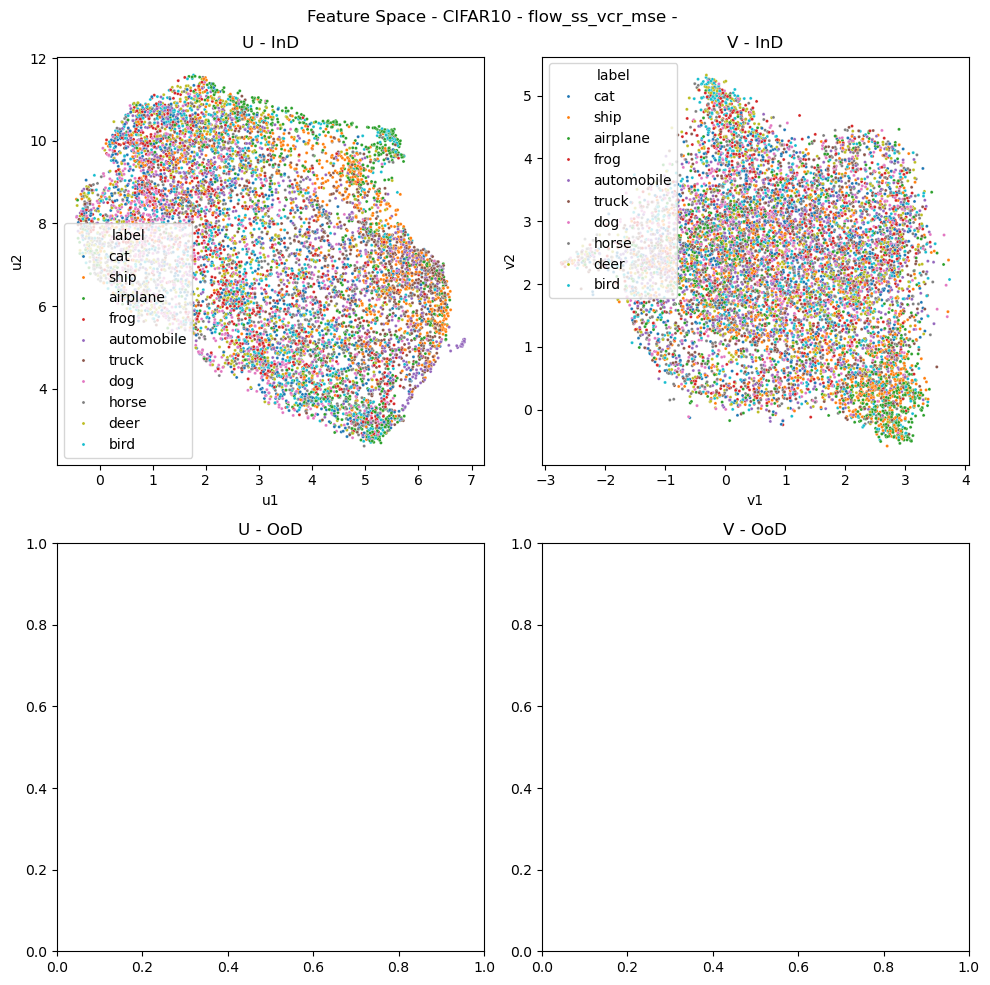

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

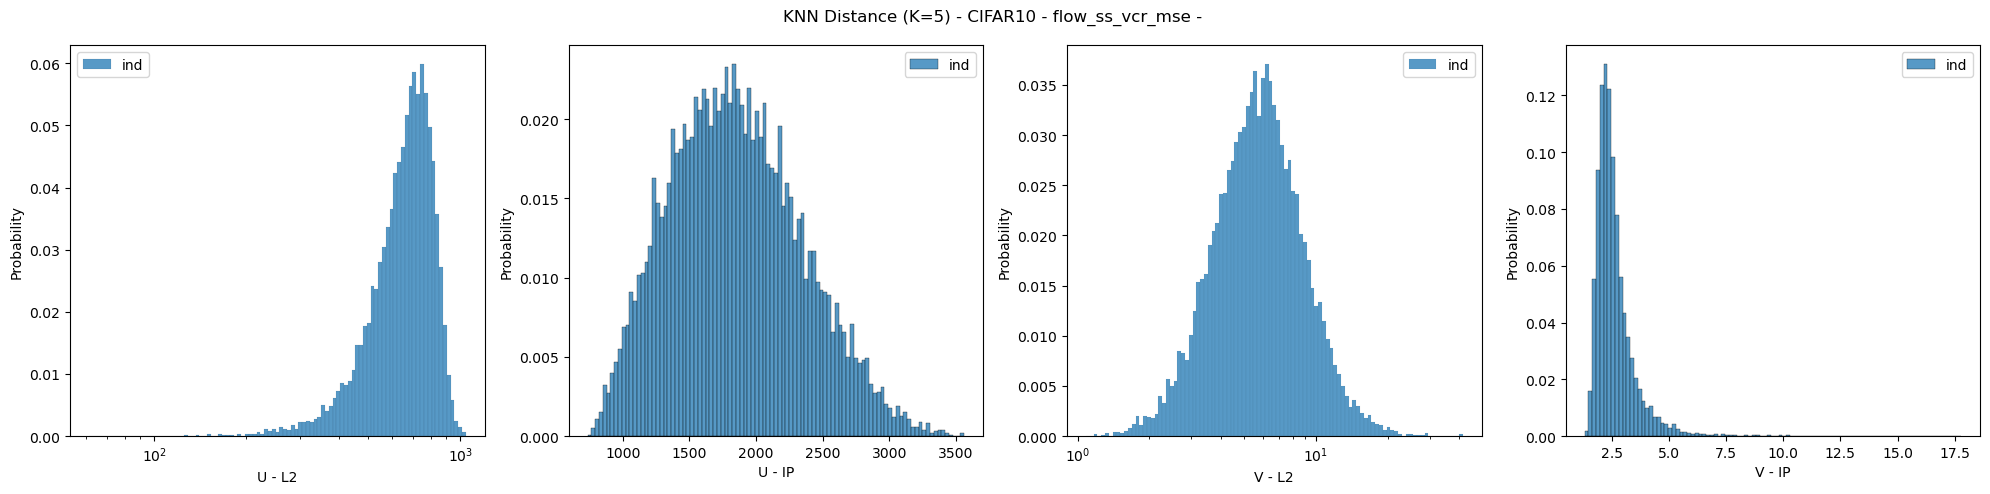

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

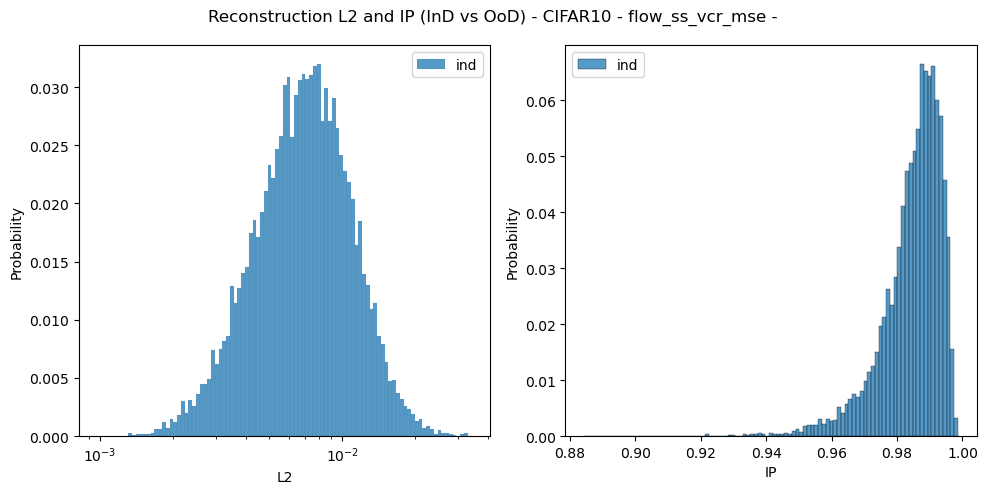

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

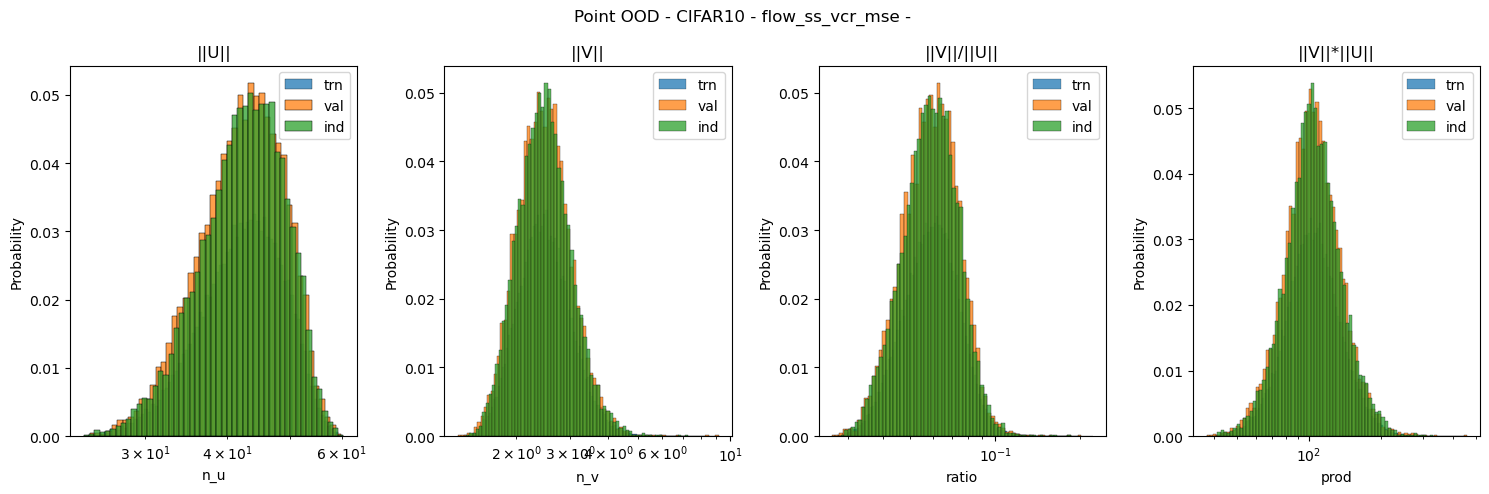

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


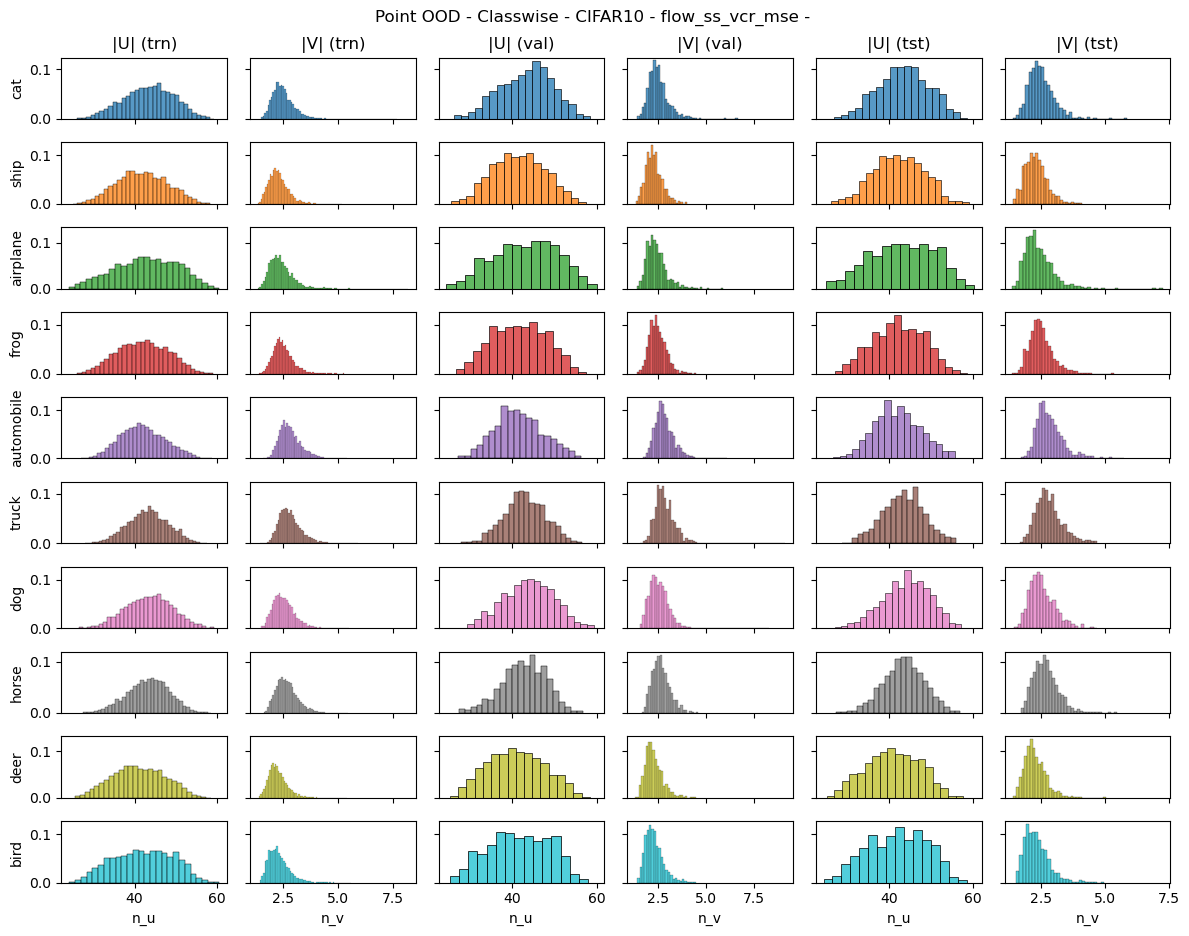

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

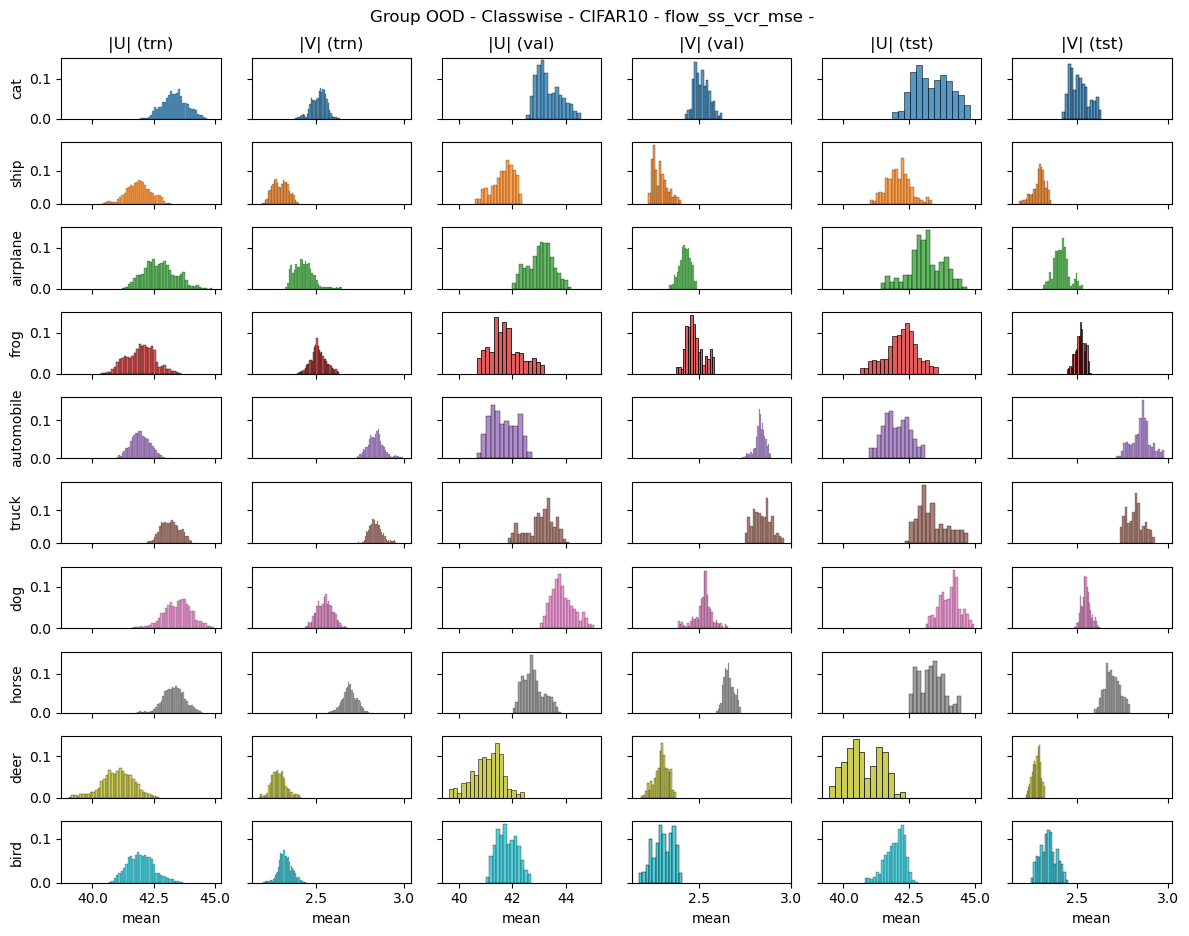

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)